# Prague Pedestrian Accessibility for Children (age 10-16)

### Installing packages

I will use OSMnx - a Python package by Geoff Boeing to work with street networks: retrieve, construct, analyze, and visualize street networks (and more) from OpenStreetMap.
<a>https://github.com/gboeing/osmnx</a>.

In [7]:
!conda update --all

Solving environment: - 
  - conda-forge::libgfortran-3.0.0-1
  - defaults::libgfortran-3.0.0done

## Package Plan ##

  environment location: /opt/conda/envs/Python36


The following packages will be UPDATED:

    ca-certificates: 2018.10.15-ha4d7672_0     conda-forge/label/gcc7 --> 2019.8.28-0            
    certifi:         2018.8.24-py36_1001       conda-forge/label/gcc7 --> 2019.9.11-py36_0       
    cryptography:    2.3.1-py36hb7f436b_1000   conda-forge/label/gcc7 --> 2.7-py36h1ba5d50_0     
    curl:            7.63.0-h646f8bb_1000      conda-forge/label/gcc7 --> 7.65.3-hbc83047_0      
    freetds:         1.00.97-hc365091_0                               --> 1.00.97-h1ba5d50_0     
    gdal:            2.3.2-py36h2924dbc_0                             --> 2.3.3-py36hbb2a789_0   
    geos:            3.6.2-heeff764_2                                 --> 3.7.1-he6710b0_0       
    grpcio:          1.16.0-py36h4f00d22_1000  conda-forge/label/gcc7 --> 1.16.1-py36hf8bcb03_1  
    h5

In [4]:
!conda install -c conda-forge/label/gcc7 osmnx

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - osmnx


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    thrift-cpp-0.11.0          |       hc04171f_3         2.3 MB
    libevent-2.1.8             |       h93c0eb6_0         1.4 MB
    ------------------------------------------------------------
                                           Total:         3.7 MB

The following packages will be UPDATED:

    fiona:           1.8.4-py36hc38cc03_0    --> 1.8.4-py36heb36068_1001   conda-forge/label/gcc7
    freetds:         1.00.97-h1ba5d50_0      --> 1.00.97-hc365091_0                              
    kealib:          1.4.7-hd0c454d_6        --> 1.4.7-h77bc034_6                                
    krb5:            1.16.1-h173b8e3_7       --> 1.16.2-hc83ff2d_1000      conda-forge/label/gcc7
    libarchive:      3.3.

Installing gecoder. A simple and consistent geocoding library

In [ ]:
!conda install -c conda-forge geocoder

Importing all nessecary libraries

In [1]:
import osmnx as ox
import io
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import folium
import geocoder
import json
import urllib.request
import requests
from pandas.io.json import json_normalize
import operator
from shapely.geometry import Polygon
import geopandas as gpd

## Data acquisition and cleaning

As main data source I sellected <a>http://opendata.praha.eu</a>.  This is a big database of data of different types amd it contains data from different fileds: transport, society, ecology, population e.t.c  
This data sets were mainly colleted and structured by Prague Institute of Planning and Development <a>www.iprpraha.cz</a> For my project I mainly intrested in:
* Shape and location of Prague administrative districs
* Districts population
* Geo location different types of social infrastructure 

First step is to determine the shape and location of the administrative disctrics of Prague.

In [2]:
mestky_casty_url = 'http://opendata.iprpraha.cz/CUR/DTMP/TMMESTSKECASTI_P/WGS_84/TMMESTSKECASTI_P.json'
results = requests.get(mestky_casty_url).json(encoding = "utf8")
mestky_casty = json_normalize(results['features']) 
mestky_casty.head()

,type,geometry.type,geometry.coordinates,properties.OBJECTID,properties.DAT_VZNIK,properties.DAT_ZMENA,properties.PLOCHA,properties.ID,properties.KOD_MC,properties.NAZEV_MC,properties.KOD_MO,properties.KOD_SO,properties.TID_TMMESTSKECASTI_P,properties.POSKYT,properties.ID_POSKYT,properties.STAV_ZMENA,properties.NAZEV_1,properties.Shape_Length,properties.Shape_Area
0,Feature,Polygon,"[[[14.533725418000074, 50.16223134300003], [14...",1,20181106141412,20190423111436,10183715.88,25,547310,Praha-Čakovice,94,221,25,HMP-IPR,43,U,Čakovice,0.213162,1.018372e+07
1,Feature,Polygon,"[[[14.293206908000059, 50.07751405400006], [14...",2,20181106141412,20181106164427,3253142.41,52,547174,Praha 17,60,213,52,HMP-IPR,43,U,Praha 17,0.095029,3.253142e+06
2,Feature,Polygon,"[[[14.483934895000061, 49.99241857800007], [14...",3,20181009145125,20190821104230,5234736.54,19,547051,Praha-Libuš,43,124,19,HMP-IPR,43,U,Libuš,0.200404,5.234737e+06
3,Feature,Polygon,"[[[14.506905018000054, 50.17143575600005], [14...",4,20170817145228,20170818091113,3380681.90,35,538124,Praha-Březiněves,86,86,35,HMP-IPR,43,U,Březiněves,0.127235,3.380682e+06
4,Feature,Polygon,"[[[14.43852135000003, 50.06691477800007], [14....",5,20180910110223,20180910113234,4184937.95,30,500089,Praha 2,27,27,30,HMP-IPR,43,U,Praha 2,0.134652,4.184938e+06


In [3]:
mestky_casty.shape

(57, 19)

In [4]:
geo_unique = np.array(mestky_casty['properties.NAZEV_MC'].apply(lambda x: x.lower()).unique())
geo_unique

array(['praha-čakovice', 'praha 17', 'praha-libuš', 'praha-březiněves',
       'praha 2', 'praha 1', 'praha 11', 'praha-zbraslav', 'praha 15',
       'praha 4', 'praha 5', 'praha 20', 'praha-dolní měcholupy',
       'praha 6', 'praha 9', 'praha 10', 'praha 14', 'praha 12',
       'praha-kolovraty', 'praha-újezd', 'praha 13', 'praha-řeporyje',
       'praha-suchdol', 'praha-ďáblice', 'praha-šeberov',
       'praha-dolní chabry', 'praha 19', 'praha-koloděje',
       'praha-satalice', 'praha-petrovice', 'praha 3',
       'praha-velká chuchle', 'praha-dolní počernice',
       'praha-přední kopanina', 'praha-královice', 'praha-kunratice',
       'praha-slivenec', 'praha-vinoř', 'praha-lochkov', 'praha-nebušice',
       'praha-benice', 'praha 18', 'praha-křeslice', 'praha-troja',
       'praha 7', 'praha-nedvězí', 'praha 21', 'praha-běchovice',
       'praha-štěrboholy', 'praha-dubeč', 'praha-lysolaje',
       'praha-lipence', 'praha 8', 'praha 22', 'praha-zličín', 'praha 16',
       'praha-

Districts population

In [5]:
url_population =  'https://www.czso.cz/documents/10180/25233177/sldb_zv.csv'
df_population = pd.read_csv(url_population,encoding = "ISO 8859-2")
df_population.head()

,typuz_naz,nazev,uzcis,uzkod,u01,u02,u03,u04,u05,u06,u07,u08,u09,u10,u11
0,kraj,Hlavní město Praha,100,3018,1268796.0,613738.0,655058.0,153622.0,908321.0,201029.0,644643.0,600730.0,92927.0,542168.0,579509.0
1,kraj,Středočeský kraj,100,3026,1289211.0,637252.0,651959.0,199300.0,895024.0,190911.0,639851.0,587539.0,286780.0,482860.0,523045.0
2,kraj,Jihočeský kraj,100,3034,628336.0,308296.0,320040.0,91119.0,435187.0,100000.0,307130.0,280844.0,123048.0,247608.0,262692.0
3,kraj,Plzeňský kraj,100,3042,570401.0,282137.0,288264.0,79469.0,396468.0,92734.0,278674.0,255278.0,105835.0,226298.0,242397.0
4,kraj,Karlovarský kraj,100,3051,295595.0,145483.0,150112.0,42159.0,207480.0,44538.0,139871.0,123100.0,39845.0,119403.0,128904.0


Cleaning population data set. For my project only make sence data 

In [6]:
df_population = df_population[(df_population.uzcis == 44)& (df_population.nazev.str.find('Praha') != -1)][['nazev','u01','u04', 'u05', 'u06']]
df_population.rename(columns={'nazev':'Name','u01':'Total', 'u04':'Kids', 'u05':'Middle', 'u06':'Senior'}, inplace = True)
df_population['Name'] = df_population['Name'].map(lambda x: x.lower())
df_population.shape

(57, 5)

Quick analizing of distrcit population

In [7]:
population_unique = df_population['Name'].unique()
population_unique

array(['praha 1', 'praha 2', 'praha 3', 'praha 4', 'praha 5', 'praha 6',
       'praha 7', 'praha 8', 'praha 9', 'praha 10', 'praha-běchovice',
       'praha-benice', 'praha-březiněves', 'praha-dolní počernice',
       'praha-dubeč', 'praha 20', 'praha-klánovice', 'praha-koloděje',
       'praha-kolovraty', 'praha-královice', 'praha-křeslice',
       'praha-nedvězí', 'praha-satalice', 'praha 22', 'praha 21',
       'praha-vinoř', 'praha-lipence', 'praha-lochkov',
       'praha-přední kopanina', 'praha 16', 'praha-řeporyje',
       'praha-slivenec', 'praha 13', 'praha-\x8aeberov', 'praha-újezd',
       'praha-zbraslav', 'praha-zličín', 'praha 11', 'praha-kunratice',
       'praha-libu\x9a', 'praha 12', 'praha-velká chuchle',
       'praha-lysolaje', 'praha-nebu\x9aice', 'praha 17', 'praha-suchdol',
       'praha-ďáblice', 'praha-dolní chabry', 'praha-čakovice',
       'praha-troja', 'praha 19', 'praha 14', 'praha-dolní měcholupy',
       'praha 15', 'praha-petrovice', 'praha-\x8atěrboho

Checking the difference between to datasets

In [8]:
districts_diff_geo = list(set(geo_unique)-set(population_unique))
districts_diff_geo

['praha-štěrboholy', 'praha-nebušice', 'praha-šeberov', 'praha-libuš']

In [9]:
districts_diff_pop = list(set(population_unique)-set(geo_unique))
districts_diff_pop

['praha-nebu\x9aice',
 'praha-\x8aeberov',
 'praha-libu\x9a',
 'praha-\x8atěrboholy']

Population data set has encoding errors. Lets fix it

In [10]:
df_population.loc[df_population.Name == 'praha-libu\x9a', 'Name'] = 'praha-libuš'
df_population.loc[df_population.Name == 'praha-\x8aeberov', 'Name'] = 'praha-šeberov'
df_population.loc[df_population.Name == 'praha-nebu\x9aice', 'Name'] = 'praha-nebušice'
df_population.loc[df_population.Name == 'praha-\x8atěrboholy', 'Name'] = 'praha-štěrboholy'

In [11]:
population_unique = df_population['Name'].unique()
districts_diff_pop = list(set(population_unique)-set(geo_unique))
districts_diff_pop

[]

Districts dataset and population dataset have the same districs. Lets make a join of two data sets

In [12]:
result = []

result.append([
    v['properties']['NAZEV_MC'].lower(),
    v['geometry']['coordinates'][0],
    v['properties']['PLOCHA']] for v in results['features'])
    
df_prague_districts = pd.DataFrame([item for result in result for item in result])
df_prague_districts.columns = ['Name', 'Geometry', 'Area']

In [13]:
df_prague = df_prague_districts.set_index('Name').join(df_population.set_index('Name'))
quotient = df_prague['Middle']/1000
df_prague['Kids_per_1000'] = df_prague['Kids']/quotient
df_prague.sort_values('Name', inplace = True)
df_prague.head()

,Geometry,Area,Total,Kids,Middle,Senior,Kids_per_1000
Name,,,,,,,
praha 1,"[[14.410891049000043, 50.078674687000046], [14...",5538443.86,30561.0,2391.0,22963.0,4594.0,104.124026
praha 10,"[[14.531321086000048, 50.072240288000046], [14...",18599366.98,113200.0,12213.0,76625.0,23937.0,159.386623
praha 11,"[[14.54355294800007, 50.03618763800006], [14.5...",9793679.84,75741.0,8688.0,54983.0,11816.0,158.012477
praha 12,"[[14.450632163000023, 50.01452735600003], [14....",23317909.06,53515.0,6156.0,39699.0,7480.0,155.066878
praha 13,"[[14.320621949000042, 50.04010680700003], [14....",13196802.19,59906.0,7985.0,46514.0,5109.0,171.668745


In [14]:
df_prague.shape

(57, 7)

In [15]:
dict_coordinates = {}
for index, row in df_prague.iterrows():
    g = geocoder.arcgis(index)
    lat = g.json['lat']
    lng = g.json['lng']
    dict_coordinates[index] = [lat, lng]
    
df_prague['latitude'] = 0.0
df_prague['longitude'] = 0.0
for k, v in dict_coordinates.items():
    df_prague.loc[df_prague.index == k,'latitude']=v[0]
    df_prague.loc[df_prague.index == k,'longitude']=v[1]
    
df_prague.head()

,Geometry,Area,Total,Kids,Middle,Senior,Kids_per_1000,latitude,longitude
Name,,,,,,,,,
praha 1,"[[14.410891049000043, 50.078674687000046], [14...",5538443.86,30561.0,2391.0,22963.0,4594.0,104.124026,50.08728,14.41742
praha 10,"[[14.531321086000048, 50.072240288000046], [14...",18599366.98,113200.0,12213.0,76625.0,23937.0,159.386623,50.06762,14.46016
praha 11,"[[14.54355294800007, 50.03618763800006], [14.5...",9793679.84,75741.0,8688.0,54983.0,11816.0,158.012477,50.03178,14.50719
praha 12,"[[14.450632163000023, 50.01452735600003], [14....",23317909.06,53515.0,6156.0,39699.0,7480.0,155.066878,50.00564,14.40462
praha 13,"[[14.320621949000042, 50.04010680700003], [14....",13196802.19,59906.0,7985.0,46514.0,5109.0,171.668745,50.05163,14.34231


Explore children popupualtion in Prague

In [16]:
g = geocoder.arcgis('Prague')
print('Prague latitude {} longitude {}'.format(g.json['lat'],g.json['lng']))

Prague latitude 50.07913000000008 longitude 14.433020000000056


In [ ]:
prague_map = folium.Map(location=[g.json['lat'], g.json['lng']], width=750, height=500, zoom_start = 12)

In [17]:
polygon = [Polygon(x) for x in df_prague.Geometry]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(df_prague, crs=crs, geometry=polygon)

In [18]:
gdf.head()

,Geometry,Area,Total,Kids,Middle,Senior,Kids_per_1000,latitude,longitude,geometry
Name,,,,,,,,,,
praha 1,"[[14.410891049000043, 50.078674687000046], [14...",5538443.86,30561.0,2391.0,22963.0,4594.0,104.124026,50.08728,14.41742,"POLYGON ((14.41089104900004 50.07867468700005,..."
praha 10,"[[14.531321086000048, 50.072240288000046], [14...",18599366.98,113200.0,12213.0,76625.0,23937.0,159.386623,50.06762,14.46016,"POLYGON ((14.53132108600005 50.07224028800005,..."
praha 11,"[[14.54355294800007, 50.03618763800006], [14.5...",9793679.84,75741.0,8688.0,54983.0,11816.0,158.012477,50.03178,14.50719,"POLYGON ((14.54355294800007 50.03618763800006,..."
praha 12,"[[14.450632163000023, 50.01452735600003], [14....",23317909.06,53515.0,6156.0,39699.0,7480.0,155.066878,50.00564,14.40462,"POLYGON ((14.45063216300002 50.01452735600003,..."
praha 13,"[[14.320621949000042, 50.04010680700003], [14....",13196802.19,59906.0,7985.0,46514.0,5109.0,171.668745,50.05163,14.34231,"POLYGON ((14.32062194900004 50.04010680700003,..."


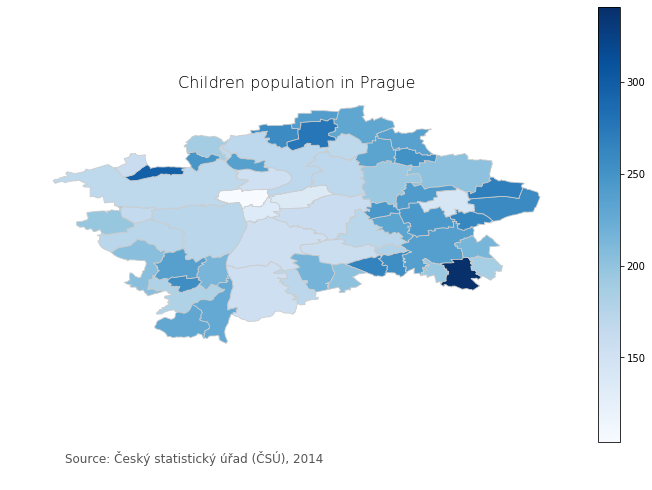

In [31]:
variable = 'Kids_per_1000'
vmin = round(gdf['Kids_per_1000'].min())
vmax = round(gdf['Kids_per_1000'].max()) 
fig, ax = plt.subplots(1, figsize=(12, 8))

ax.axis('off')
ax.set_title('Children population in Prague', fontdict={'fontsize': '16', 'fontweight' : '3'})
ax.annotate('Source: Český statistický úřad (ČSÚ), 2014',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
gdf.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

In [ ]:
map_p = ox.graph_from_address('Prague',network_type='walk', simplify=True)
ox.plot_graph(map_p)